# What  
- 商品説明(text)を用いて、類似商品を抽出する    
  
# Why  
- 過去にある顧客がA商品を買っている場合、Aと類似商品を購入する可能性がある    
- article_idをkeyとして、類似商品をvalueとするようなjsonが欲しい    
  
# How    
- (データ数を削減)  
- 前処理  
- tsdfでembedding  
- SVDで次元圧縮  
- 近傍探索  

※  articles全データをSVDで次元圧縮しようとするとメモリエラー

# Config

In [1]:
# articles.csvをサンプリング (全データを使うとkaggle notebookだと落ちる)
SAMPLING = 10000

# NearestNeighbors (類似しているN個の商品を抽出)
N_NEIGHBORDHOOD = 12

In [2]:
!pip install swifter==0.260
import swifter
import nltk
import re
import string
import re
import cv2, os
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import pickle

  Preparing metadata (setup.py) ... - done
  Created wheel for swifter: filename=swifter-0.260-py3-none-any.whl size=4013 sha256=66fb534d5ec0440ecb74bccfc77d07103b360f4523d3ad8548d66e63052a903f
  Stored in directory: /root/.cache/pip/wheels/bd/c8/5f/45eabee9e4bfbcc90ec0ece7d970703285ebf926b06ba1e640
Successfully built swifter


In [3]:
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
transactions = pd.read_parquet('../input/hm01-solution-warmup/transactions_train.parquet')

In [4]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
len(articles)

105542

In [6]:
# detail_descのみ欠損あり
# 24  detail_desc                   105126 non-null  object
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

# (相談)2020年9月誰も購入していないものは廃盤 or 品切れとみなして削除  
- 廃盤のものが類似商品として推薦されても嬉しくない

In [7]:
"""
# 101week以上に限定
transactions = transactions[transactions['week']>=101]

# 101week以降で販売実績のある商品idを抽出
unique_id = transactions['article_id'].unique()
print(len(unique_id))

print(len(articles['article_id'].unique()))

# 8/26(101week)に一回でも販売された商品に限定
articles = articles[articles['article_id'].isin(unique_id)].reset_index(drop=True)
"""

"\n# 101week以上に限定\ntransactions = transactions[transactions['week']>=101]\n\n# 101week以降で販売実績のある商品idを抽出\nunique_id = transactions['article_id'].unique()\nprint(len(unique_id))\n\nprint(len(articles['article_id'].unique()))\n\n# 8/26(101week)に一回でも販売された商品に限定\narticles = articles[articles['article_id'].isin(unique_id)].reset_index(drop=True)\n"

In [8]:
# メモリエラーが起きるのでデータをサンプリング
N = 30000 # debugなら5000が良さげ
articles = articles.sample(N).reset_index(drop=True)

# 前処理・可視化

In [9]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

from nltk.corpus import stopwords
nltk.download('stopwords')


#===== ストップワード =====
stop_words_nltk = nltk.corpus.stopwords.words('english')

def del_eng_stop_words(text):
    #!マークなども消したいので正規表現で空文字に置換
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    sample = regex.sub("", text)
    
    #小文字にして、stop wordsに入っていなければリストに追加
    words = [w.lower()  for w in sample.split(" ") \
                 if not w.lower()  in stop_words_nltk]
    words=' '.join(words)
    return words

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# 欠損値補完
articles["detail_desc"] = articles["detail_desc"].fillna(" ")

# 商品説明以外のtxt情報も使用 (色とか)
articles["text"] = articles.apply(
    lambda x: " ".join(
        [
            str(x["prod_name"]),
            str(x["product_type_name"]),
            str(x["product_group_name"]),
            str(x["graphical_appearance_name"]),
            str(x["colour_group_name"]),
            str(x["perceived_colour_value_name"]),
            str(x["index_name"]),
            str(x["section_name"]),
            str(x["detail_desc"])
        ]
    ),
    axis=1,
)

# stop word削除
articles["text"] = articles["text"].swifter.apply(lambda x:del_eng_stop_words(x))

Pandas Apply: 100%|██████████| 30000/30000 [00:02<00:00, 11541.15it/s]


In [11]:
text = ' '.join(articles["text"]) #各曲を長い一つのリストに統合
words = [w for w in text.split(" ")]  #textをスペース区切りでリストに格納
word_count = Counter(words)

<Figure size 2160x1440 with 0 Axes>

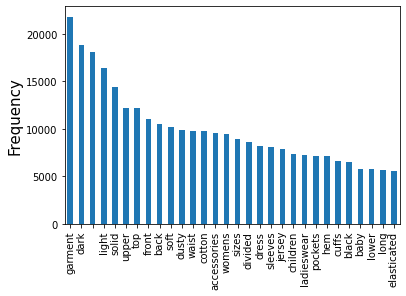

In [12]:
# DataFrameに格納
df_count = pd.DataFrame.from_dict(word_count,orient='index').reset_index()
df_count.columns=["word","count"]
df_count.sort_values("count",ascending=False,inplace=True)
df_count=df_count.iloc[1:,:]

#可視化
plt.figure(figsize = (30,20))
ax=df_count.iloc[:30,:].plot.bar()
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xticklabels(
    df_count.iloc[:30,:]["word"],
    fontdict = {
        'fontsize':10,
    }
)
ax.legend_.remove()
plt.show()

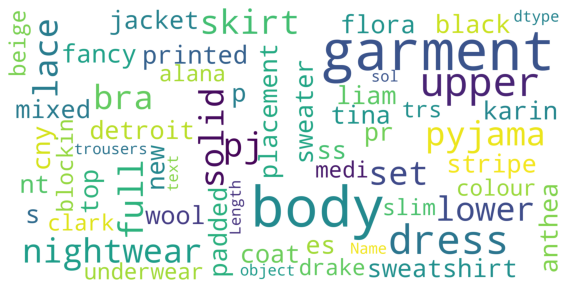

In [13]:
from wordcloud import WordCloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=3000,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
    
show_wordcloud(articles["text"])

# ts-idf / 次元圧縮

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(articles["text"])
X=X.toarray()

In [15]:
X.shape

(30000, 10147)

## 可視化

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

"""svd= TruncatedSVD(n_components=2)
svd_tfidf = svd.fit_transform(X)"""

tsne= TSNE(n_components=2)
tsne_tfidf = tsne.fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


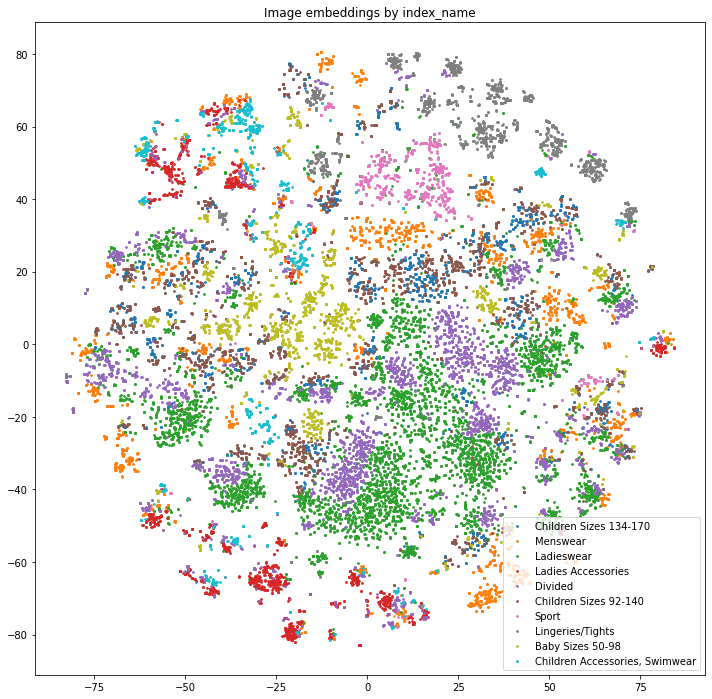

In [17]:
## 全然うまく行っていない
fig = plt.figure(figsize=(12, 12))

for index_name in articles.index_name.unique():
    #plt.scatter(svd_tfidf[articles.index_name == index_name, 0], svd_tfidf[articles.index_name == index_name, 1], label=index_name, s=3)
    plt.scatter(tsne_tfidf[articles.index_name == index_name, 0], tsne_tfidf[articles.index_name == index_name, 1], label=index_name, s=3)

plt.title("Image embeddings by index_name")
plt.legend()
plt.show()

# 近傍探索  
- 画像のread方法を変えているので注意  
https://www.kaggle.com/hamditarek/similar-image-cnn-cosine-similarity

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

svd= TruncatedSVD(n_components=20)
svd_tfidf = svd.fit_transform(X)

In [19]:
df_svd_tfidf = pd.DataFrame(svd_tfidf)
df_svd_tfidf = df_svd_tfidf.add_prefix('svd_') 
df_svd_tfidf["article_id"] = articles["article_id"]

In [20]:
def preprocess_img(img_path):
    dsize = (225,225)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize,interpolation=cv2.INTER_NEAREST)  
    new_image=np.expand_dims(new_image,axis=0)
    new_image=preprocess_input(new_image)
    return new_image


images_dir = '../input/h-and-m-personalized-fashion-recommendations/images'

In [21]:
def input_show(data):
    plt.title("Query Image")
    plt.imshow(data)
    
def show_result(df, result):
    fig = plt.figure(figsize=(12,8))
    for i in range(0,12):
        index_result=result[0][i]
        image_path = f'../input/h-and-m-personalized-fashion-recommendations/images/0{str(df.article_id[index_result])[:2]}/0{int(df.article_id[index_result])}.jpg'
        plt.subplot(3,4,i+1)
        plt.imshow(cv2.imread(image_path))
        plt.title(index_result)
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()

In [22]:
def result_vector_cosine(feature_vector,new_feature):
    new_feature = np.array(new_feature)
    new_feature = new_feature.flatten()
    nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORDHOOD, metric="cosine").fit(feature_vector)
    distances, indices = nbrs.kneighbors([new_feature])
    return(indices)

########## query detail_desc ##########
Jumper in a soft, fine knit with long sleeves and ribbing around the neckline, cuffs and hem.


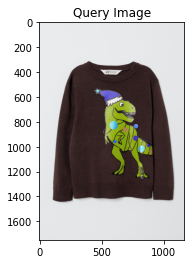

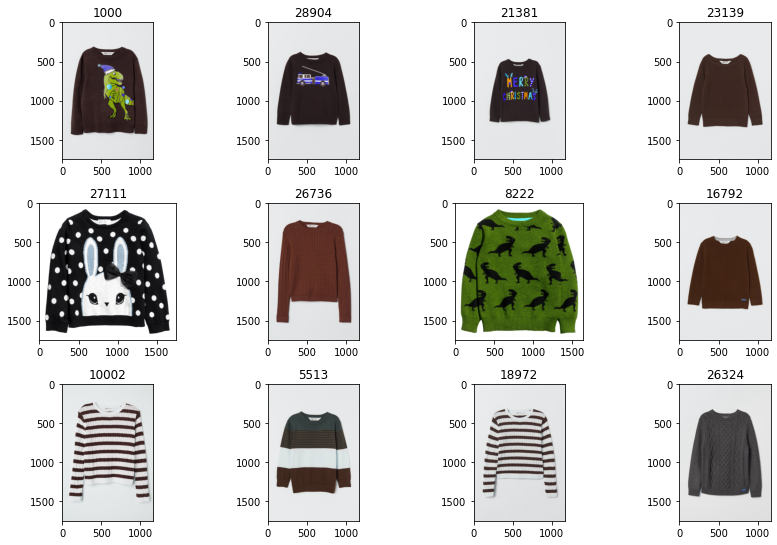

In [23]:
i = 1000
result = result_vector_cosine(svd_tfidf,svd_tfidf[i])
print("########## query detail_desc ##########")
print(articles.detail_desc[i])
output_path = f'../input/h-and-m-personalized-fashion-recommendations/images/0{str(articles.article_id[i])[:2]}/0{int(articles.article_id[i])}.jpg'
input_show(cv2.imread(output_path))
show_result(articles, result)

########## query detail_desc ##########
Chelsea boots with elastic gores in the sides and a loop front and back. Cotton canvas linings and insoles. Heel 2 cm. The polyester content of the boots is partly recycled.


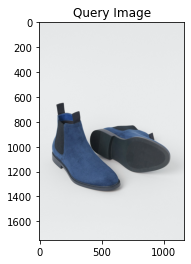

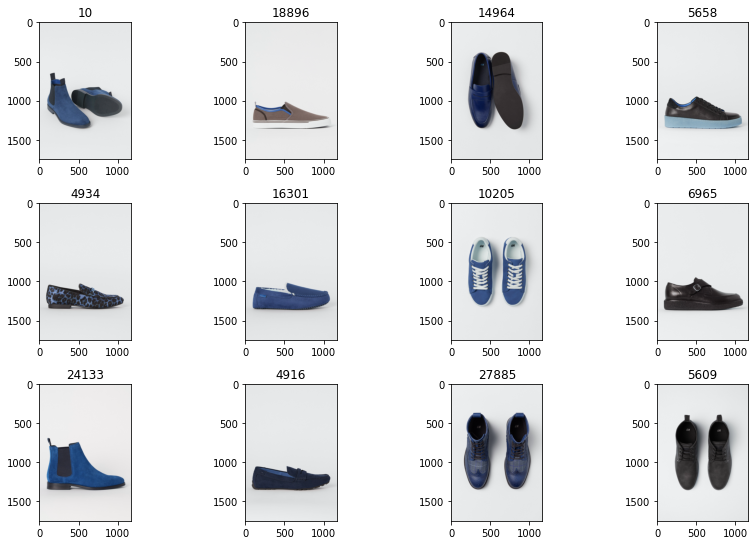

In [24]:
i = 10
result = result_vector_cosine(svd_tfidf,svd_tfidf[i])
print("########## query detail_desc ##########")
print(articles.detail_desc[i])
output_path = f'../input/h-and-m-personalized-fashion-recommendations/images/0{str(articles.article_id[i])[:2]}/0{int(articles.article_id[i])}.jpg'
input_show(cv2.imread(output_path))
show_result(articles, result)

########## query detail_desc ##########
Short, sleeveless dress in a viscose weave with embroidered details and a small stand-up collar. Narrow-cut back with a zip and fastener at the back of the neck. Seam at the waist and a gently flared skirt.


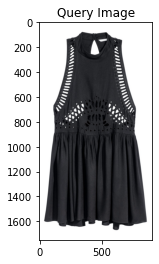

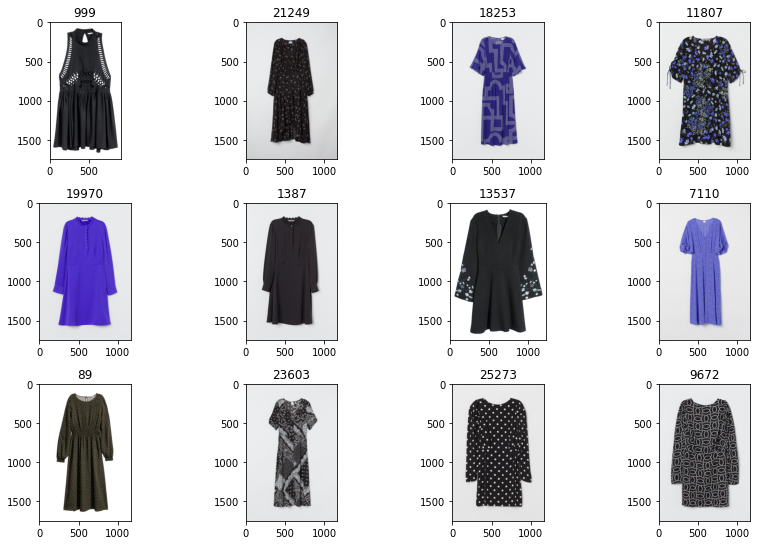

In [25]:
i = 999
result = result_vector_cosine(svd_tfidf,svd_tfidf[i])
print("########## query detail_desc ##########")
print(articles.detail_desc[i])
output_path = f'../input/h-and-m-personalized-fashion-recommendations/images/0{str(articles.article_id[i])[:2]}/0{str(articles.article_id[i])}.jpg'
input_show(cv2.imread(output_path))
show_result(articles, result)

# 出力の作成  
- similar_article_text.json  
    - key: article_id  
    - value: N個の類似article_id , list  
- item_vecs.json  
    - key: article_id  
    - value: article_idのtext情報を20次元に圧縮したベクトル

In [26]:
%%time
output_dict = {}
keys = articles.article_id

for i, key in enumerate(keys):
    output_dict[key] = result_vector_cosine(svd_tfidf,svd_tfidf[i]).tolist()[0]
    
    
with open('similar_article_text.json', 'wb') as fp:
    pickle.dump(output_dict, fp)

CPU times: user 8min 20s, sys: 7min 11s, total: 15min 32s
Wall time: 3min 57s


In [27]:
%%time
item_vecs = {}
keys = articles.article_id

for i, key in enumerate(keys):
    item_vecs[key] = svd_tfidf[i].tolist()
    
with open('item_vecs.json', 'wb') as fp:
    pickle.dump(item_vecs, fp)

CPU times: user 319 ms, sys: 16.3 ms, total: 335 ms
Wall time: 333 ms


In [28]:
item_vecs

{719731001: [0.22153418715614653,
  0.03664211365180697,
  0.0835154105362938,
  -0.0056078009478223185,
  0.13041068137935158,
  -0.056045054854270665,
  -0.03683375764441251,
  -0.03240297236409881,
  0.0077764253817802515,
  -0.027044604599462473,
  0.025940818957869927,
  -0.006209066737420325,
  -0.04573715295084248,
  -0.037492301112609254,
  -0.013375351878172995,
  0.18173935072075056,
  0.028802423537156396,
  0.12794636589387573,
  0.1821851644602274,
  0.20732385278960247],
 551044018: [0.3430559740240787,
  -0.13249946959531128,
  -0.25723329825500224,
  -0.14403165894983155,
  -0.14165257702049444,
  -0.07480125007339973,
  -0.04962770542384853,
  -0.14625436679190867,
  0.001017612629705279,
  0.01963686724405935,
  -0.012799849392559987,
  -0.06790681085785985,
  0.09835696653795321,
  -0.10852188366840469,
  0.024695901431784146,
  -0.042720174597444316,
  -0.000941054988968292,
  -0.05427147214276708,
  0.11276179251646677,
  -0.10761250301425226],
 745736001: [0.23790